# Importation des bibliothéques

In [12]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import nltk

from sklearn.model_selection import train_test_split
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer
from nltk.stem import WordNetLemmatizer
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

from sklearn.metrics import classification_report
from sklearn.utils import class_weight
from collections import Counter


[nltk_data] Downloading package punkt to /home/anyes/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/anyes/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /home/anyes/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Chargement des données

In [2]:
df = pd.read_csv('../Scrapped_Data/Data_APEC_all/all_data_V1_cleaned.csv')
df

,entreprise,type_contrat,date_publication,date_mise_a_jour,salaire,prise_de_poste,experience,metier,statut_du_poste,zone_de_deplacement,...,profil_recherche,langues,savoir_etre,savoir_faire,descriptif_entreprise,nombre_posts,duree,ville,code_postal,departement
0,MICHAEL PAGE INTERNATIONAL FRANCE,CDI,2024-02-29,2024-02-29,40.0,Dès que possible,0,Développeur,Cadre du secteur privé,Pas de déplacement,...,"De formation supérieure en informatique, vous ...",Aucune langue attendue,"['Autonomie', ""Capacité d'analyse"", 'Capacité ...","['Application Web', 'Développement web', 'Info...",Notre client est un éditeur de logiciels dans ...,1,NaN,Aix-en-Provence,13,Bouches-du-Rhône
1,Charlotte Drahy sas,CDI,2024-01-17,2024-03-15,40.0,Dès que possible,5,Développeur,Cadre du secteur privé,Nationale,...,Les compétences requises sont :\nProgrammation...,"Anglais, Français","[""Esprit d'équipe"", 'Motivation', 'Rigueur']","['Analyse des besoins', 'Analyse fonctionnelle...","""Charlotte Drahy sas"" est une société de conse...",1,NaN,Aubagne,13,Bouches-du-Rhône
2,LOEMA,CDI,2024-02-22,2024-02-22,47.5,Dès que possible,4,Développeur,Cadre du secteur privé,Pas de déplacement,...,Vous avez une expérience en : \n- Programma...,Aucune langue attendue,"['Curiosité', 'Goût du challenge']","['ASP.NET', 'Bootstrap Protocol', 'C sharp', '...",Situé au cœur même de la ville de Marseille no...,1,NaN,Marseille,13,Bouches-du-Rhône
3,CELAD,CDI,2024-02-29,2024-02-29,36.0,Dès que possible,1,Développeur,Cadre du secteur privé,Pas de déplacement,...,"Idéalement ingénieur de formation, vous justif...",Aucune langue attendue,"['Autonomie', 'Force de proposition', 'Qualité...","['Framework', 'JavaScript', 'ReactJS', 'TypeSc...","Issu du monde bancaire, #CELAD a été créée en ...",1,NaN,Aix-en-Provence,13,Bouches-du-Rhône
4,EASY PARTNER,CDI,2024-03-01,2024-03-01,40.0,Dès que possible,3,Développeur,Cadre du secteur privé,Pas de déplacement,...,Profil recherché\nNous recherchons un profil a...,Aucune langue attendue,"['Ambition', 'Autonomie', 'Bienveillance', 'Ca...","['Nuxt', 'Vue.js', 'Développement web', 'React...",Easy Partner est un Cabinet de recrutement dig...,1,NaN,Aix-en-Provence,13,Bouches-du-Rhône
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8037,Seyos,CDI,2024-03-15,2024-03-15,52.5,Dès que possible,5,Business developer,Cadre du secteur privé,Pas de déplacement,...,Profil recherché :\nVous avez une expérience s...,Aucune langue attendue,"['Force de proposition', 'Proactivité']","['Manutention', 'Automatisme', 'Cahier des cha...",Seyos est un cabinet de recrutement spécialisé...,1,NaN,Tonneins,47,Lot-et-Garonne
8038,LES COLETTES,CDI,2024-03-12,2024-03-12,NaN,Dès que possible,2,Ingénieur test et recettes,Cadre du secteur privé,Pas de déplacement,...,"Issu(e) d'une formation en informatique, idéal...",Aucune langue attendue,"[""Esprit d'équipe""]","['Cloud', 'Jira', 'SAAS', 'Algorithme', 'Autom...",Editeur de logiciels français multi-sectoriel ...,1,NaN,Villeneuve-sur-Lot,47,Lot-et-Garonne
8039,Armée de l'Air et de l'Espace,CDD,2024-02-21,2024-02-21,34.0,Dès que possible,0,Consultant en cybersécurité,Cadre du secteur public / Armées,Nationale,...,"Jeune diplômé, avec ou sans expérience profess...",Anglais,"[""Capacité d'adaptation"", 'Capacité de communi...","['Analyse des risques', 'Gestion de projet', '...",L’armée de l’Air et de l’Espace a pour mission...,1,de 5 mois,Saint-Dizier,52,Haute-Marne
8040,Armée de l'Air et de l'Espace,CDD,2024-02-16,2024-02-16,22.5,Dès que possible,0,Responsable sécurité informatique,Cadre du secteur public / Armées,Nationale,...,"Diplômé, avec ou sans expérience professionnel...",Anglais,"[""Capacité d'adaptation"", 'Capacité de communi...","['Analyse des risques', 'Gestion de projet', '...",L’armée de l’Air et de l’Espace a pour mission...,1,de 5 mois,Saint-Dizier,52,Haute-Marne


# Prétraitement

## Prétraitement des données

In [3]:
def remove_ponctuation(sentence):
    punc = string.punctuation
    punc += '\n\r\t'
    sentence = sentence.translate(str.maketrans(punc, ' ' * len(punc)))
    sentence = re.sub('( )+', ' ', sentence)  # Supprimer les espaces en trop
    return sentence

def remove_numbers(sentence):
    return re.sub('[0-9]+', '', sentence)

def remove_stopwords_Fr(sentence):
    stop_words = set(stopwords.words('french'))
    additional_stop_words = {'informatique', 'gestion', 'management', 'projet', 'équipe', 'mission', 'client'}
    stop_words.update(additional_stop_words)
    tokens = nltk.word_tokenize(sentence)
    filtered_sentence = [word.lower()  for word in tokens if word.lower() not in stop_words]
    return " ".join(filtered_sentence)

In [6]:
df["preprocessed_description"] = df["descriptif_poste"].apply(lambda x: remove_stopwords_Fr(remove_numbers(remove_ponctuation(x))))
df[["preprocessed_description"]]

,preprocessed_description
0,tant développeur web fonctions conception déve...
1,motivé rigoureux concevez développez applicati...
2,recherche développeur web full stack net core ...
3,poursuivons développement sud recrutons e ingé...
4,contexte poste entreprise ancrée secteur touri...
...,...
8037,description représentons groupe accès industri...
8038,entouré e passionné e enjeux poste testeur aut...
8039,faire appliquer politique sécurité réglementat...
8040,faire appliquer politique sécurité réglementat...


## Prétraitement des labels

In [7]:
def map_metier_to_label(metier):
    data = ['Administrateur data center', 'Administrateur de bases de données', 'Architecte Big Data', 'Business analyst', 'Chief Data Officer', 'Data analyst', 'Data engineer', 'Data scientist', 'Délégué à la protection']
    reseaux = ['Administrateur réseaux', 'Administrateur système', 'Architecte infrastructures', 'Architecte réseaux', 'Architecte système', 'Ingénieur de maintenance informatique', 'Ingénieur de production informatique', 'Ingénieur informatique industrielle', 'Ingénieur réseaux', 'Ingénieur système', 'Ingénieur télécoms']
    dev = ['Architecte développement', 'Business developer', 'Consultant technique progiciel', 'Développeur' ,'Ingénieur R&D', 'Ingénieur en études et développement informatiques', 'Ingénieur informatique embarquée', 'Ingénieur intégration progiciel', 'Ingénieur test et recettes', 'Ingénieur test et essai']
    chef_projet = ['Chef de projet Agile', 'Chef de projet R&D', 'Chef de projet digital', 'Chef de projet fonctionnel web', 'Chef de projet informatique', 'Chef de projet informatique décisionnelle', 'Directeur de projets informatiques', 'Project management officer', 'Responsable informatique']
    cybersecu = ['Consultant en cybersécurité', 'Ingénieur sécurité informatique', 'Responsable sécurité informatique']

    if metier in data:
        return 0
    elif metier in reseaux:
        return 1
    elif metier in dev:
        return 2
    elif metier in chef_projet:
        return 3
    elif metier in cybersecu:
        return 4
    else:
        return 5

In [8]:
df['label'] = df['metier'].apply(map_metier_to_label)

In [9]:
filtred_df = df[["preprocessed_description" , "label"]]
filtred_df

,preprocessed_description,label
0,tant développeur web fonctions conception déve...,2
1,motivé rigoureux concevez développez applicati...,2
2,recherche développeur web full stack net core ...,2
3,poursuivons développement sud recrutons e ingé...,2
4,contexte poste entreprise ancrée secteur touri...,2
...,...,...
8037,description représentons groupe accès industri...,2
8038,entouré e passionné e enjeux poste testeur aut...,2
8039,faire appliquer politique sécurité réglementat...,4
8040,faire appliquer politique sécurité réglementat...,4


### Distribution plot

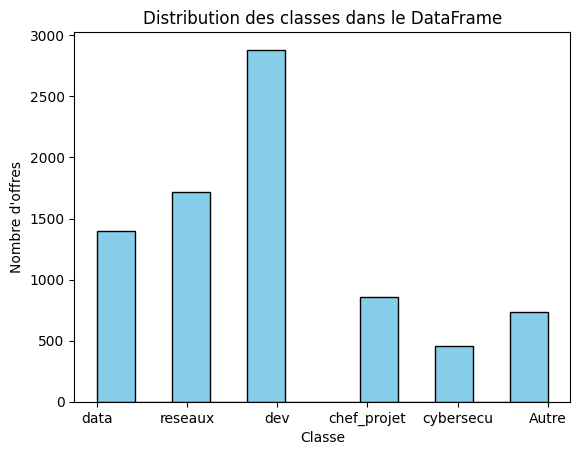

In [10]:
plt.hist(filtred_df['label'], bins=12, color='skyblue', edgecolor='black')  
plt.title('Distribution des classes dans le DataFrame')  
plt.xlabel('Classe')  
plt.ylabel('Nombre d\'offres')  
plt.xticks([0, 1 , 2 , 3 , 4 , 5], labels= ["data" , "reseaux" , "dev" , "chef_projet" , "cybersecu" , "Autre"])  # Définir les étiquettes de l'axe x
plt.show()

D'aprés ce plot, on remarque que nos classes sont déséquilibrées

## Diviser les données en Train/Test

In [11]:
train_ind , test_ind = train_test_split(filtred_df.index , test_size=0.2, shuffle = True , random_state=42)

train_df = filtred_df.loc[train_ind , :]
test_df = filtred_df.loc[test_ind , :]

print("All dataset shape : ", filtred_df.shape)
print("Train shape : ", train_df.shape)
print("Test shape : ",test_df.shape)

All dataset shape :  (8042, 2)
Train shape :  (6433, 2)
Test shape :  (1609, 2)


### Equilibrer Training set

In [19]:
min_train_count = train_df["label"].value_counts().min()
min_train_count

370

In [20]:
train_df = pd.concat([group.sample(min_train_count) for name , group in train_df.groupby("label")])

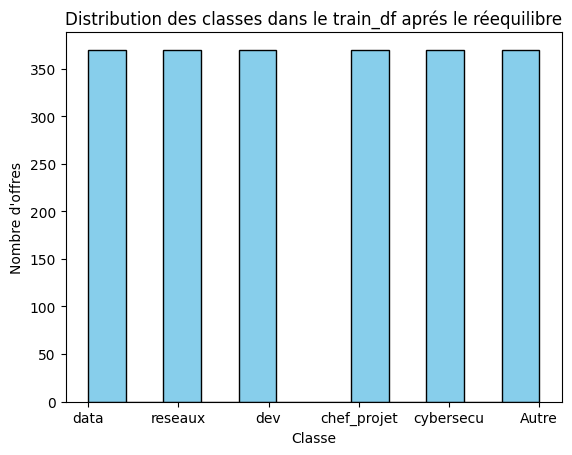

In [21]:
plt.hist(train_df['label'], bins=12, color='skyblue', edgecolor='black')  
plt.title('Distribution des classes dans le train_df aprés le réequilibre')  
plt.xlabel('Classe')  
plt.ylabel('Nombre d\'offres')  
plt.xticks([0, 1 , 2 , 3 , 4 , 5], labels= ["data" , "reseaux" , "dev" , "chef_projet" , "cybersecu" , "Autre"])  # Définir les étiquettes de l'axe x
plt.show()

# Lancement du modéle

## Tokenization

In [22]:
import torch
from transformers import FlaubertModel, FlaubertTokenizer

# Choose among ['flaubert/flaubert_small_cased', 'flaubert/flaubert_base_uncased', 
#               'flaubert/flaubert_base_cased', 'flaubert/flaubert_large_cased']
modelname = 'flaubert/flaubert_base_cased' 

# Load pretrained model and tokenizer
flaubert, log = FlaubertModel.from_pretrained(modelname, output_loading_info=True)
flaubert_tokenizer = FlaubertTokenizer.from_pretrained(modelname, do_lowercase=False)
# do_lowercase=False if using cased models, True if using uncased ones

sentence = "Le chat mange une pomme."
token_ids = torch.tensor([flaubert_tokenizer.encode(sentence)])

last_layer = flaubert(token_ids)[0]
print(last_layer.shape)
# torch.Size([1, 8, 768])  -> (batch size x number of tokens x embedding dimension)

# The BERT [CLS] token correspond to the first hidden state of the last layer
cls_embedding = last_layer[:, 0, :]

/home/anyes/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
